In [680]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from scipy import stats

import shap
shap.initjs()

In [681]:
df = pd.read_csv('C:/Users/hugod/Downloads/Dados/NYC Ap/nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [682]:
#Dropping columns that won't will help us to create our prediction model
del df['EASE-MENT']
del df['Unnamed: 0']
del df['SALE DATE']

In [683]:
#Checking for duplicated entries, avoiding add noise to the model
sum(df.duplicated(df.columns))

1358

In [684]:
#Checking again for duplicated entries, avoiding add noise to the model
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

In [685]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83190 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         83190 non-null  int64 
 1   NEIGHBORHOOD                    83190 non-null  object
 2   BUILDING CLASS CATEGORY         83190 non-null  object
 3   TAX CLASS AT PRESENT            83190 non-null  object
 4   BLOCK                           83190 non-null  int64 
 5   LOT                             83190 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83190 non-null  object
 7   ADDRESS                         83190 non-null  object
 8   APARTMENT NUMBER                83190 non-null  object
 9   ZIP CODE                        83190 non-null  int64 
 10  RESIDENTIAL UNITS               83190 non-null  int64 
 11  COMMERCIAL UNITS                83190 non-null  int64 
 12  TOTAL UNITS                     83190 non-null

In [686]:
df['BOROUGH'] = df['BOROUGH'].astype('category')
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')

df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7,NaN
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7,NaN
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0


In [687]:
df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [688]:
miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.167196
LAND SQUARE FEET     0.312213
GROSS SQUARE FEET    0.327888
dtype: float64

In [689]:
miss=miss.to_frame()
miss.columns=['count']
miss.index.names=['Name']
miss['Name']=miss.index
miss

,count,Name
Name,,
SALE PRICE,0.167196,SALE PRICE
LAND SQUARE FEET,0.312213,LAND SQUARE FEET
GROSS SQUARE FEET,0.327888,GROSS SQUARE FEET


<module 'seaborn' from 'C:\\Users\\hugod\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

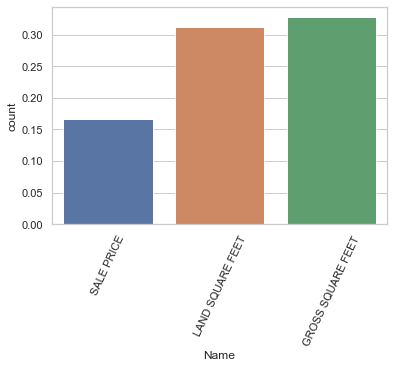

In [690]:
#plot the missing values
sns.set(style='whitegrid',color_codes=True)
sns.barplot(x='Name', y='count',data=miss)
plt.xticks(rotation=65)
sns

In [691]:
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [692]:
test=df[df['SALE PRICE'].isna()]
data=df[~df['SALE PRICE'].isna()]

In [693]:
test = test.drop(columns='SALE PRICE')

In [694]:
print(test.shape)
test.head()

(13909, 18)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,516 EAST 12TH STREET,,10009,20,0,20,2581.0,9730.0,1900,2,C4
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,520 EAST 14TH STREET,,10009,44,2,46,5163.0,21007.0,1900,2,C7
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,141 AVENUE D,,10009,15,0,15,1534.0,9198.0,1920,2,D5


In [695]:
corr = data.corr()
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.449913
TOTAL UNITS          0.126654
RESIDENTIAL UNITS    0.122566
LAND SQUARE FEET     0.060143
COMMERCIAL UNITS     0.044535
LOT                  0.012266
YEAR BUILT          -0.003779
ZIP CODE            -0.034110
BLOCK               -0.061357
Name: SALE PRICE, dtype: float64

In [696]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,6.928100e+04,6.928100e+04,69281.000000,6.928100e+04
mean,4200.305437,374.983473,10739.919458,1.870859,0.164244,2.055109,3.643061e+03,3.640300e+03,1800.113451,1.286521e+06
std,3434.828427,656.820333,1265.389144,14.317577,9.018311,17.026435,3.322172e+04,2.427118e+04,519.752668,1.145690e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1349.000000,21.000000,10306.000000,0.000000,0.000000,0.000000,1.900000e+03,1.268000e+03,1920.000000,2.350000e+05
50%,3377.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.970000e+03,2.400000e+03,1938.000000,5.350000e+05
75%,6192.000000,879.000000,11249.000000,2.000000,0.000000,2.000000,3.858418e+03,3.891878e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

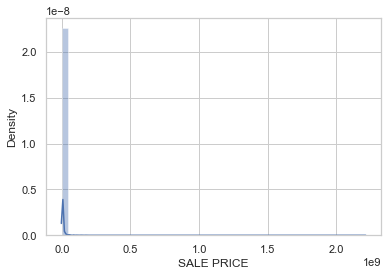

In [697]:
sns.distplot(data['SALE PRICE'])

In [698]:
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]

<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

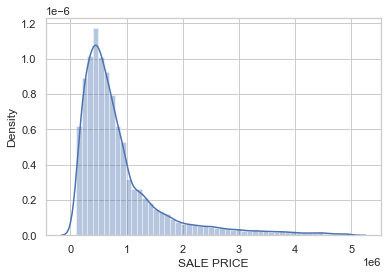

In [699]:
sns.distplot(data['SALE PRICE'])

In [700]:
data['SALE PRICE'].skew()


2.3437455096169386

0.19896303705046872


<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

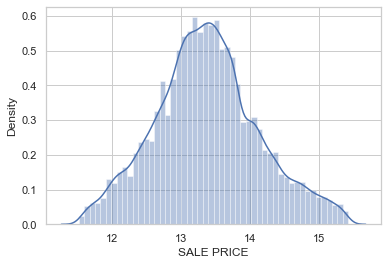

In [701]:
#SALE PRICE is highly right skewed. So, we will log transform it so that it give better results.

sales=np.log(data['SALE PRICE'])
print(sales.skew())
sns.distplot(sales)

In [702]:
data[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,24886
0,0,15550
2,2,9576
3,3,2736
4,4,708
...,...,...
40,51,1
33,34,1
38,47,1
37,39,1


In [703]:
#Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units

data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] != 2261)] 

In [704]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,39004,39004,39004,39004,39004,39004,39004,39004,39004
unique,5,248,38,9,117,31071,2643,3,117
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,R4,131-05 40TH ROAD,,1,R4
freq,12739,1677,12416,24245,8918,209,27038,25474,8922


In [705]:
'''Data Pre Processing
Let's see our dataset again'''

del data['ADDRESS']
del data['APARTMENT NUMBER']

In [706]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         39004 non-null  category
 1   NEIGHBORHOOD                    39004 non-null  object  
 2   BUILDING CLASS CATEGORY         39004 non-null  object  
 3   TAX CLASS AT PRESENT            39004 non-null  category
 4   BLOCK                           39004 non-null  int64   
 5   LOT                             39004 non-null  int64   
 6   BUILDING CLASS AT PRESENT       39004 non-null  object  
 7   ZIP CODE                        39004 non-null  int64   
 8   RESIDENTIAL UNITS               39004 non-null  int64   
 9   COMMERCIAL UNITS                39004 non-null  int64   
 10  TOTAL UNITS                     39004 non-null  int64   
 11  LAND SQUARE FEET                39004 non-null  float64 
 12  GROSS SQUARE FEET 

In [707]:
'''#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])'''

'#transform the numeric features using log(x + 1)\nfrom scipy.stats import skew\nskewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))\nskewed = skewed[skewed > 0.75]\nskewed = skewed.index\ndata[skewed] = np.log1p(data[skewed])'

In [708]:
'''scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaled = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       data[col] = scaled[:,i]'''

data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,10009,10,0,10,2272.00000,6794.000000,1913,2,C4,3936272.0
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,10009,8,0,8,1750.00000,4226.000000,1920,2,C4,3192840.0
76,1,ALPHABET CITY,12 CONDOS - WALKUP APARTMENTS,2,386,1002,R2,10009,1,0,1,3858.41804,3891.878472,0,2,R2,620000.0
79,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,373,1003,R4,10009,1,0,1,3858.41804,3891.878472,1920,2,R4,762669.0
80,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,373,1004,R4,10009,1,0,1,3858.41804,3891.878472,1920,2,R4,772851.0


In [709]:
data['SALE PRICE'] = data['SALE PRICE']/1000000


In [710]:
data['SALE PRICE'].head()

3     3.936272
6     3.192840
76    0.620000
79    0.762669
80    0.772851
Name: SALE PRICE, dtype: float64

In [711]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         39004 non-null  category
 1   NEIGHBORHOOD                    39004 non-null  object  
 2   BUILDING CLASS CATEGORY         39004 non-null  object  
 3   TAX CLASS AT PRESENT            39004 non-null  category
 4   BLOCK                           39004 non-null  int64   
 5   LOT                             39004 non-null  int64   
 6   BUILDING CLASS AT PRESENT       39004 non-null  object  
 7   ZIP CODE                        39004 non-null  int64   
 8   RESIDENTIAL UNITS               39004 non-null  int64   
 9   COMMERCIAL UNITS                39004 non-null  int64   
 10  TOTAL UNITS                     39004 non-null  int64   
 11  LAND SQUARE FEET                39004 non-null  float64 
 12  GROSS SQUARE FEET 

<AxesSubplot:title={'center':'Most Selled Neighborhood'}, xlabel='Total Sales by Neighborhood', ylabel='Sales'>

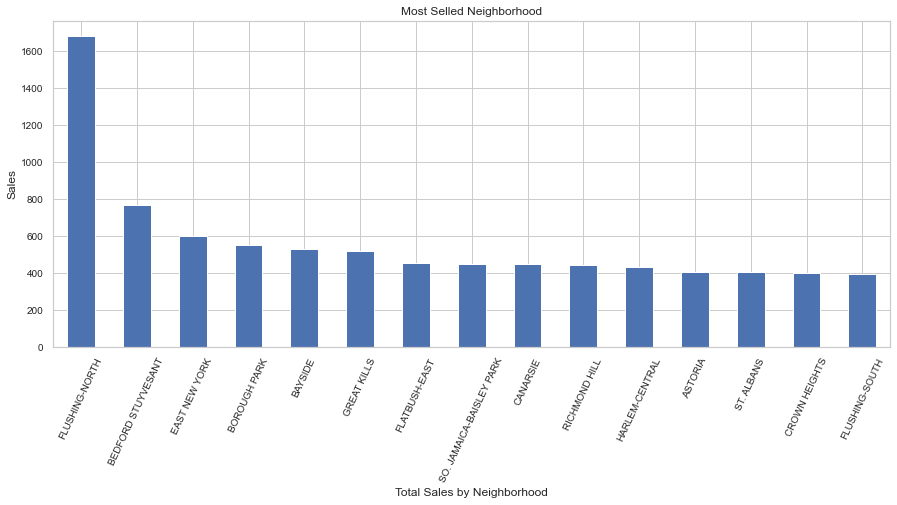

In [712]:
data['NEIGHBORHOOD'].value_counts().head(15).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Neighborhood', ylabel='Sales', title='Most Selled Neighborhood', rot = 65, fontsize=10)


In [713]:
data['BOROUGH'].value_counts()

4    12739
3    11698
5     5480
1     5462
2     3625
Name: BOROUGH, dtype: int64

<AxesSubplot:title={'center':'Most Selled Neighborhood (%)'}, xlabel='Neighborhoods', ylabel='Percentage in Sales'>

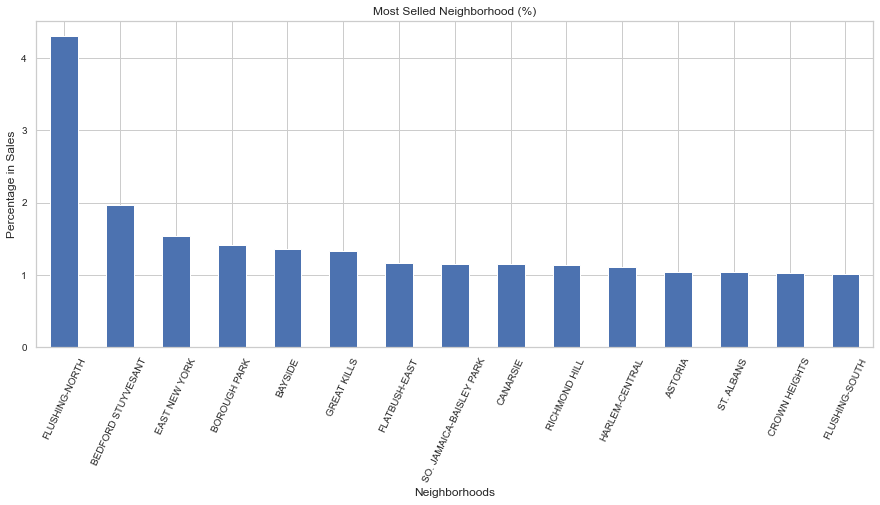

In [714]:
((data['NEIGHBORHOOD'].value_counts()/data['NEIGHBORHOOD'].count())*100).head(15).plot(kind='bar', figsize=(15, 6), xlabel='Neighborhoods', ylabel='Percentage in Sales', title='Most Selled Neighborhood (%)', rot = 65, fontsize=10)

In [715]:
print(data['BUILDING CLASS CATEGORY'].value_counts())

01 ONE FAMILY DWELLINGS                         12416
02 TWO FAMILY DWELLINGS                          9567
13 CONDOS - ELEVATOR APARTMENTS                  8922
03 THREE FAMILY DWELLINGS                        2244
07 RENTALS - WALKUP APARTMENTS                   1352
04 TAX CLASS 1 CONDOS                            1202
15 CONDOS - 2-10 UNIT RESIDENTIAL                 926
12 CONDOS - WALKUP APARTMENTS                     645
22 STORE BUILDINGS                                355
14 RENTALS - 4-10 UNIT                            285
43 CONDO OFFICE BUILDINGS                         206
29 COMMERCIAL GARAGES                             138
21 OFFICE BUILDINGS                               127
30 WAREHOUSES                                     121
44 CONDO PARKING                                   74
27 FACTORIES                                       69
45 CONDO HOTELS                                    44
46 CONDO STORE BUILDINGS                           44
37 RELIGIOUS FACILITIES     

In [716]:

data['BUILDING CLASS CATEGORY'] = data['BUILDING CLASS CATEGORY'].str.slice(start=3)
print(data['BUILDING CLASS CATEGORY'].value_counts())


ONE FAMILY DWELLINGS                         12416
TWO FAMILY DWELLINGS                          9567
CONDOS - ELEVATOR APARTMENTS                  8922
THREE FAMILY DWELLINGS                        2244
RENTALS - WALKUP APARTMENTS                   1352
TAX CLASS 1 CONDOS                            1202
CONDOS - 2-10 UNIT RESIDENTIAL                 926
CONDOS - WALKUP APARTMENTS                     645
STORE BUILDINGS                                355
RENTALS - 4-10 UNIT                            285
CONDO OFFICE BUILDINGS                         206
COMMERCIAL GARAGES                             138
OFFICE BUILDINGS                               127
WAREHOUSES                                     121
CONDO PARKING                                   74
FACTORIES                                       69
CONDO STORE BUILDINGS                           44
CONDO HOTELS                                    44
RELIGIOUS FACILITIES                            40
TAX CLASS 1 VACANT LAND        

In [717]:
data['BUILDING CLASS CATEGORY'] = data['BUILDING CLASS CATEGORY'].str.rstrip()


<AxesSubplot:title={'center':'Most Selled Borough (%)'}, ylabel='Total'>

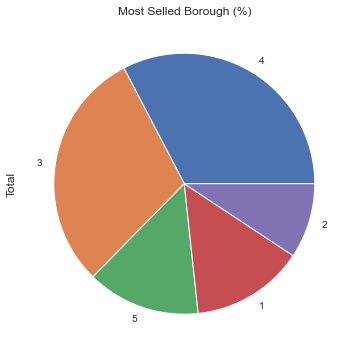

In [777]:
((data['BOROUGH'].value_counts()/data['BOROUGH'].count())*100).head(15).plot(kind='pie', figsize=(15, 6), xlabel='Total Sales by Borough', ylabel='Total', title='Most Selled Borough (%)', rot = 0, fontsize=10)

<AxesSubplot:title={'center':'Most Selled Building Class of Borough 1 - Manhattan (%)'}, xlabel='Total Sales by Borough', ylabel='Total'>

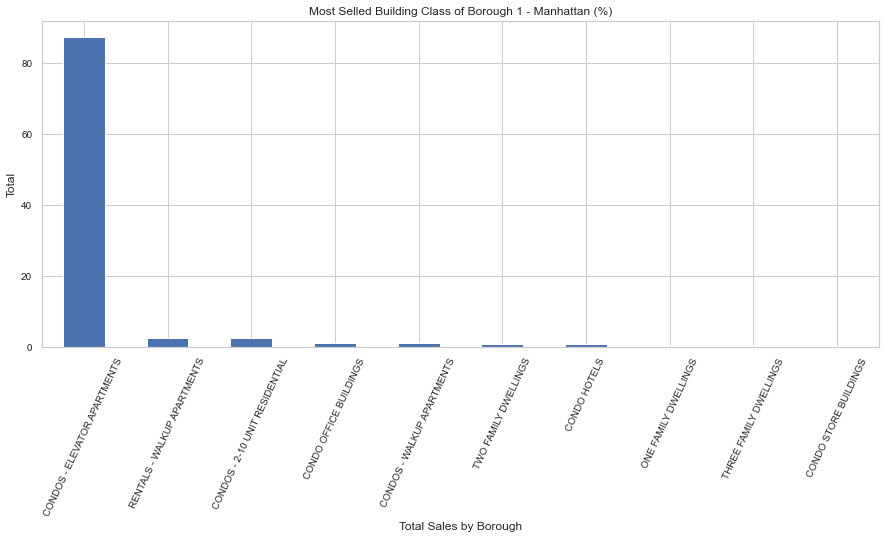

In [719]:
(((data[data['BOROUGH'] == 1]['BUILDING CLASS CATEGORY'].value_counts())/(data[data['BOROUGH'] == 1]['BUILDING CLASS CATEGORY'].count()))*100).head(10).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Borough', ylabel='Total', title='Most Selled Building Class of Borough 1 - Manhattan (%)', rot = 65, fontsize=10)

In [720]:
data[data['BOROUGH'] == 1]['SALE PRICE'].describe()

count    5462.000000
mean        1.767335
std         1.110477
min         0.107820
25%         0.900000
50%         1.439500
75%         2.401875
max         4.996841
Name: SALE PRICE, dtype: float64

<AxesSubplot:title={'center':'Most Selled Building Class of Borough 2 - The Bronx (%)'}, xlabel='Total Sales by Borough', ylabel='Total'>

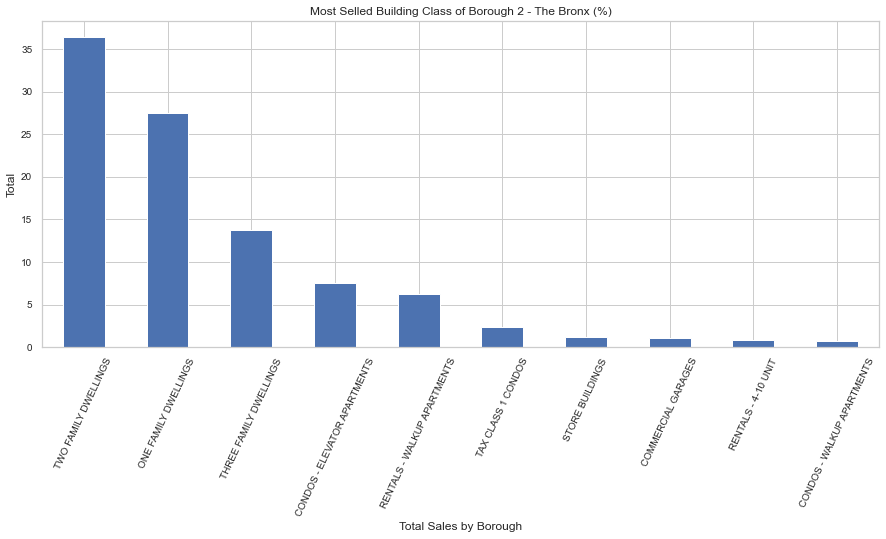

In [721]:
(((data[data['BOROUGH'] == 2]['BUILDING CLASS CATEGORY'].value_counts())/(data[data['BOROUGH'] == 2]['BUILDING CLASS CATEGORY'].count()))*100).head(10).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Borough', ylabel='Total', title='Most Selled Building Class of Borough 2 - The Bronx (%)', rot = 65, fontsize=10)

In [722]:
data[data['BOROUGH'] == 2]['SALE PRICE'].describe()

count    3625.000000
mean        0.570792
std         0.563620
min         0.101500
25%         0.334000
50%         0.460000
75%         0.600000
max         4.960000
Name: SALE PRICE, dtype: float64

<AxesSubplot:title={'center':'Most Selled Building Class of Borough 3 - Brooklyn (%)'}, xlabel='Total Sales by Borough', ylabel='Total'>

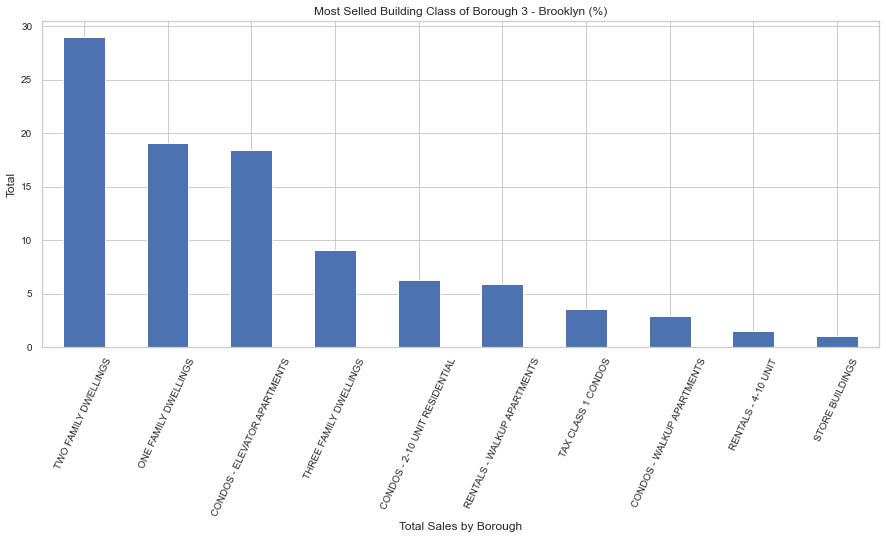

In [723]:
(((data[data['BOROUGH'] == 3]['BUILDING CLASS CATEGORY'].value_counts())/(data[data['BOROUGH'] == 3]['BUILDING CLASS CATEGORY'].count()))*100).head(10).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Borough', ylabel='Total', title='Most Selled Building Class of Borough 3 - Brooklyn (%)', rot = 65, fontsize=10)

In [724]:
data[data['BOROUGH'] == 3]['SALE PRICE'].describe()

count    11698.000000
mean         1.085832
std          0.780075
min          0.101000
25%          0.580000
50%          0.865000
75%          1.333000
max          4.975000
Name: SALE PRICE, dtype: float64

<AxesSubplot:title={'center':'Most Selled Building Class of Borough 4 - Queens (%)'}, xlabel='Total Sales by BOROUGH', ylabel='Total'>

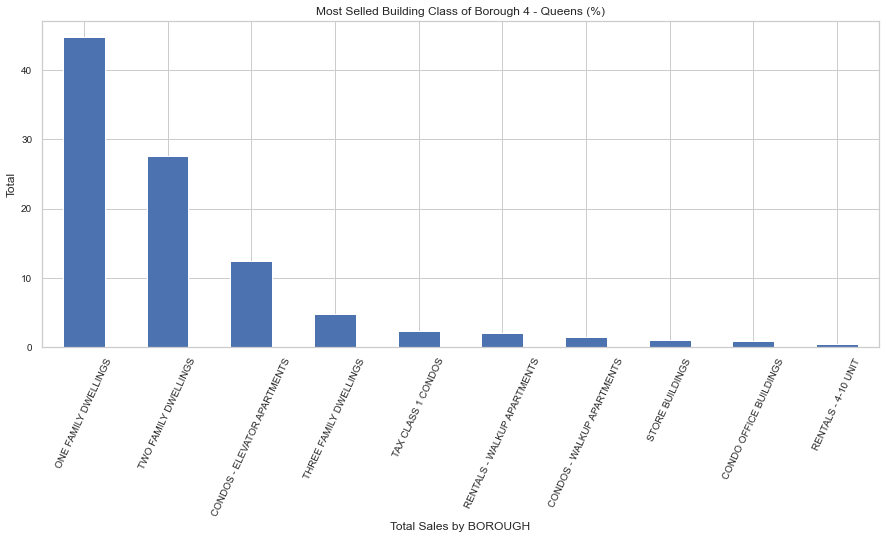

In [725]:
(((data[data['BOROUGH'] == 4]['BUILDING CLASS CATEGORY'].value_counts())/(data[data['BOROUGH'] == 4]['BUILDING CLASS CATEGORY'].count()))*100).head(10).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by BOROUGH', ylabel='Total', title='Most Selled Building Class of Borough 4 - Queens (%)', rot = 65, fontsize=10)

In [726]:
data[data['BOROUGH'] == 4]['SALE PRICE'].describe()

count    12739.000000
mean         0.724225
std          0.461022
min          0.101000
25%          0.446160
50%          0.639000
75%          0.871343
max          4.900000
Name: SALE PRICE, dtype: float64

<AxesSubplot:title={'center':'Most Selled Building Class of Borough 5 - Staten Island (%)'}, xlabel='Total Sales by BOROUGH', ylabel='Total'>

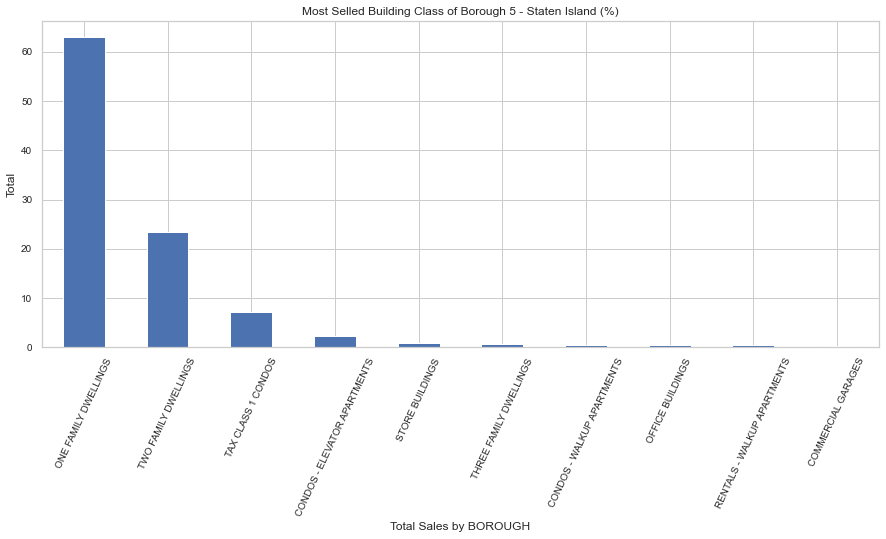

In [727]:
(((data[data['BOROUGH'] == 5]['BUILDING CLASS CATEGORY'].value_counts())/(data[data['BOROUGH'] == 5]['BUILDING CLASS CATEGORY'].count()))*100).head(10).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by BOROUGH', ylabel='Total', title='Most Selled Building Class of Borough 5 - Staten Island (%)', rot = 65, fontsize=10)

In [728]:
data[data['BOROUGH'] == 5]['SALE PRICE'].describe()

count    5480.000000
mean        0.513743
std         0.271273
min         0.100700
25%         0.355000
50%         0.475000
75%         0.610000
max         4.346648
Name: SALE PRICE, dtype: float64

<AxesSubplot:title={'center':'Most Selled Building Class Category (%)'}, xlabel='Total Sales by Building Class Category', ylabel='Building Class Category'>

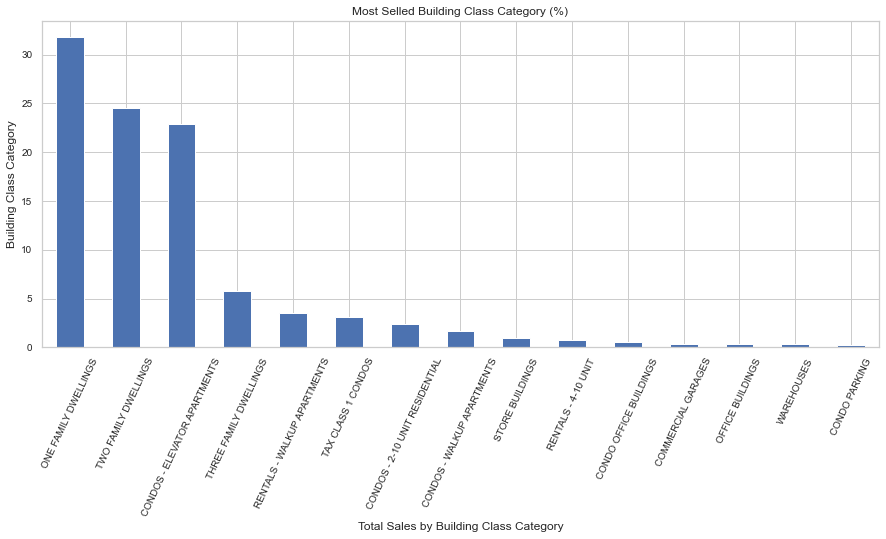

In [729]:
((data['BUILDING CLASS CATEGORY'].value_counts()/data['BUILDING CLASS CATEGORY'].count())*100).head(15).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Building Class Category', ylabel='Building Class Category', title='Most Selled Building Class Category (%)', rot = 65, fontsize=10)

<AxesSubplot:title={'center':'Most Selled Neighborhood of One Family Dwellings (%)'}, xlabel='Total Sales by Neighborhood', ylabel='Neighborhood'>

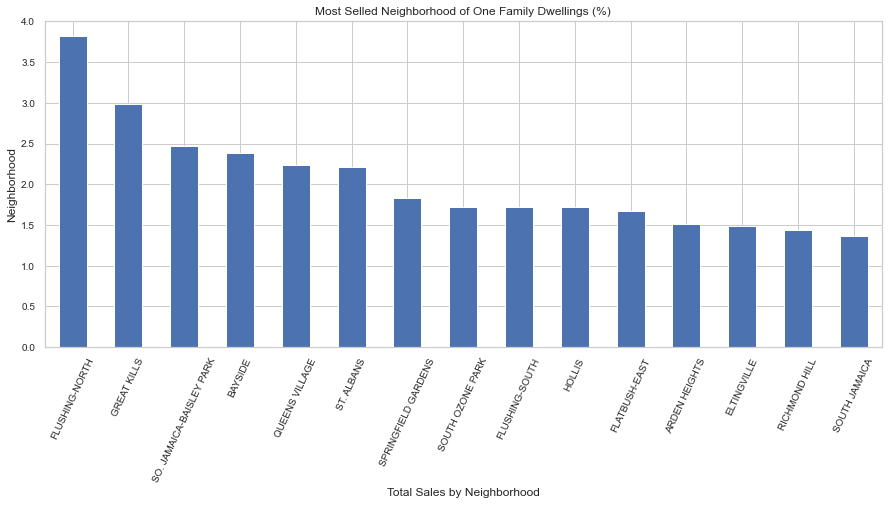

In [730]:
((data[data['BUILDING CLASS CATEGORY'] == 'ONE FAMILY DWELLINGS']['NEIGHBORHOOD'].value_counts()/data[data['BUILDING CLASS CATEGORY'] == 'ONE FAMILY DWELLINGS']['NEIGHBORHOOD'].count())*100).head(15).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Neighborhood', ylabel='Neighborhood', title='Most Selled Neighborhood of One Family Dwellings (%)', rot = 65, fontsize=10)

In [731]:
(data[data['BUILDING CLASS CATEGORY'] == 'ONE FAMILY DWELLINGS']['SALE PRICE']).describe()

count    12416.000000
mean         0.623347
std          0.426872
min          0.100700
25%          0.395000
50%          0.515000
75%          0.741625
max          4.950000
Name: SALE PRICE, dtype: float64

<AxesSubplot:title={'center':'Most Selled Neighborhood of Two Family Dwellings (%)'}, xlabel='Total Sales by Neighborhood', ylabel='Neighborhood'>

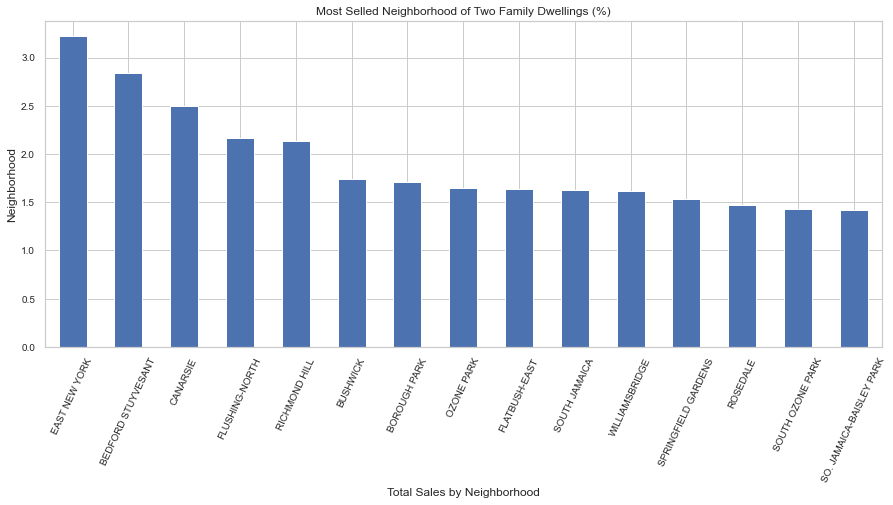

In [732]:
((data[data['BUILDING CLASS CATEGORY'] == 'TWO FAMILY DWELLINGS']['NEIGHBORHOOD'].value_counts()/data[data['BUILDING CLASS CATEGORY'] == 'TWO FAMILY DWELLINGS']['NEIGHBORHOOD'].count())*100).head(15).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Neighborhood', ylabel='Neighborhood', title='Most Selled Neighborhood of Two Family Dwellings (%)', rot = 65, fontsize=10)

In [733]:
(data[data['BUILDING CLASS CATEGORY'] == 'TWO FAMILY DWELLINGS']['SALE PRICE']).describe()


count    9567.000000
mean        0.779980
std         0.505507
min         0.101365
25%         0.485000
50%         0.665000
75%         0.925000
max         4.875000
Name: SALE PRICE, dtype: float64

<AxesSubplot:title={'center':'Most Selled Neighborhood of Condos - Elevator Apartments (%)'}, xlabel='Total Sales by Neighborhood', ylabel='Neighborhood'>

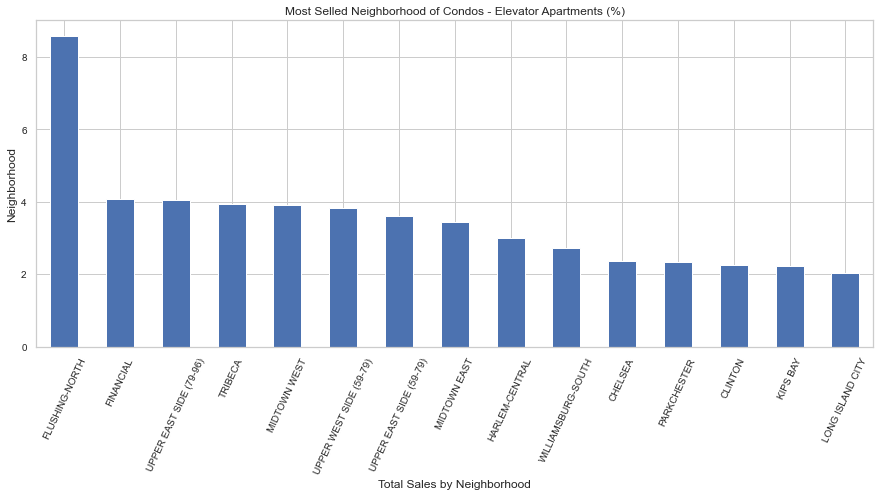

In [734]:
((data[data['BUILDING CLASS CATEGORY'] == 'CONDOS - ELEVATOR APARTMENTS']['NEIGHBORHOOD'].value_counts()/data[data['BUILDING CLASS CATEGORY'] == 'CONDOS - ELEVATOR APARTMENTS']['NEIGHBORHOOD'].count())*100).head(15).plot(kind='bar', figsize=(15, 6), xlabel='Total Sales by Neighborhood', ylabel='Neighborhood', title='Most Selled Neighborhood of Condos - Elevator Apartments (%)', rot = 65, fontsize=10)


In [735]:

(data[data['BUILDING CLASS CATEGORY'] == 'CONDOS - ELEVATOR APARTMENTS']['SALE PRICE']).describe()


count    8922.000000
mean        1.356464
std         1.005973
min         0.101825
25%         0.670819
50%         0.999999
75%         1.750000
max         4.996841
Name: SALE PRICE, dtype: float64

In [736]:
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']
del data['LAND SQUARE FEET']

#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']

In [737]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 58 columns):
 #   Column                                                           Non-Null Count  Dtype
---  ------                                                           --------------  -----
 0   BOROUGH_1                                                        39004 non-null  uint8
 1   BOROUGH_2                                                        39004 non-null  uint8
 2   BOROUGH_3                                                        39004 non-null  uint8
 3   BOROUGH_4                                                        39004 non-null  uint8
 4   BOROUGH_5                                                        39004 non-null  uint8
 5   BUILDING CLASS CATEGORY_ CONDO-RENTALS                           39004 non-null  uint8
 6   BUILDING CLASS CATEGORY_ASYLUMS AND HOMES                        39004 non-null  uint8
 7   BUILDING CLASS CATEGORY_COMMERCIAL CONDOS                 

In [742]:
# Replacing categorical columns with dummies
fdf = data.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 67 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   BLOCK                                                            39004 non-null  int64  
 1   LOT                                                              39004 non-null  int64  
 2   ZIP CODE                                                         39004 non-null  int64  
 3   RESIDENTIAL UNITS                                                39004 non-null  int64  
 4   COMMERCIAL UNITS                                                 39004 non-null  int64  
 5   TOTAL UNITS                                                      39004 non-null  int64  
 6   GROSS SQUARE FEET                                                39004 non-null  float64
 7   YEAR BUILT                              

In [743]:
fdf.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BOROUGH_1,...,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4,TAX CLASS AT TIME OF SALE_1,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_3,TAX CLASS AT TIME OF SALE_4
count,39004.000000,39004.000000,39004.000000,39004.000000,39004.000000,39004.000000,3.900400e+04,39004.00000,39004.000000,39004.000000,...,39004.000000,39004.000000,39004.000000,39004.000000,39004.0,39004.000000,39004.000000,39004.000000,39004.0,39004.000000
mean,4687.116629,463.701108,10900.753077,1.733130,0.081838,1.823941,2.646478e+03,1830.45480,0.934919,0.140037,...,0.250846,0.029920,0.007871,0.024536,0.0,0.033612,0.653113,0.313199,0.0,0.033689
std,3732.041158,714.459440,622.174455,10.708881,1.042009,10.860949,2.086446e+04,475.07583,0.787423,0.347030,...,0.433506,0.170369,0.088370,0.154708,0.0,0.180230,0.475986,0.463800,0.0,0.180429
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.00000,0.100700,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,1532.000000,28.000000,10312.000000,1.000000,0.000000,1.000000,1.280000e+03,1920.00000,0.460000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
50%,4010.000000,62.000000,11214.000000,1.000000,0.000000,1.000000,2.000000e+03,1940.00000,0.688000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000
75%,6799.000000,1027.000000,11360.000000,2.000000,0.000000,2.000000,3.891878e+03,1986.00000,1.082100,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.0,0.000000
max,16319.000000,9106.000000,11694.000000,1844.000000,126.000000,1866.000000,3.750565e+06,2017.00000,4.996841,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000


In [779]:
corr = fdf.corr()
corr['SALE PRICE'].sort_values(ascending=False).head(15)


'''  1. Manhattan (New York County)
     2. The Bronx (Bronx County)
     3. Brooklyn (Kings County)
     4. Queens (Queens County)
     5. Staten Island (Richmond County)'''

SALE PRICE                                              1.000000
BOROUGH_1                                               0.426598
TAX CLASS AT TIME OF SALE_2                             0.345782
TAX CLASS AT PRESENT_2                                  0.293453
BUILDING CLASS CATEGORY_CONDOS - ELEVATOR APARTMENTS    0.291554
BUILDING CLASS CATEGORY_RENTALS - WALKUP APARTMENTS     0.166577
TAX CLASS AT TIME OF SALE_4                             0.145026
TAX CLASS AT PRESENT_4                                  0.144650
TAX CLASS AT PRESENT_2B                                 0.130020
BOROUGH_3                                               0.125444
TAX CLASS AT PRESENT_2A                                 0.094011
BUILDING CLASS CATEGORY_RENTALS - 4-10 UNIT             0.079417
BUILDING CLASS CATEGORY_STORE BUILDINGS                 0.077839
COMMERCIAL UNITS                                        0.075288
BUILDING CLASS CATEGORY_WAREHOUSES                      0.066892
Name: SALE PRICE, dtype: 

In [745]:
fdf = fdf.drop('ZIP CODE', axis=1)
fdf = fdf.drop('BLOCK', axis=1)
fdf = fdf.drop('LOT', axis=1)

Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)


X_fdf.shape , Y_fdf.shape

((39004, 63), (39004,))

In [746]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.2 , random_state=0)
# Training set
X_train.shape , Y_train.shape

((31203, 63), (31203,))

In [747]:
#Modelling
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))



In [790]:
#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test,Y_pred_lin)



0.6315281192244215

In [791]:
#Lasso Regression
alpha=0.00099
lasso_regr=Lasso(alpha=alpha,max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso=lasso_regr.predict(X_test)
rmse(Y_test,Y_pred_lasso)


0.6348795213548708

In [831]:

#Ridge Regression
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
rmse(Y_test,Y_pred_ridge)




0.6314417868266196

In [832]:
X_fdf['GROSS SQUARE FEET'].describe()

count    3.900400e+04
mean     2.646478e+03
std      2.086446e+04
min      0.000000e+00
25%      1.280000e+03
50%      2.000000e+03
75%      3.891878e+03
max      3.750565e+06
Name: GROSS SQUARE FEET, dtype: float64

In [793]:
#RandomForest Regressor
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test,Y_pred_rf)

0.5770157367936897

In [817]:
importance = pd.DataFrame(list(zip(X_train.columns, np.transpose(rf_regr.feature_importances_))) \
            ).sort_values(1, ascending=False)
importance

,0,1
3,GROSS SQUARE FEET,0.320693
5,BOROUGH_1,0.243337
4,YEAR BUILT,0.193955
7,BOROUGH_3,0.070748
0,RESIDENTIAL UNITS,0.030621
...,...,...
21,BUILDING CLASS CATEGORY_CONDO TERRACES/GARDENS...,0.000043
15,BUILDING CLASS CATEGORY_CONDO CULTURAL/MEDICAL...,0.000040
48,TAX CLASS AT PRESENT_,0.000000
57,TAX CLASS AT PRESENT_3,0.000000


In [854]:
#XGBOOST
xb_reg = XGBRegressor(n_estimators=8000, learning_rate=0.001)
xb_reg.fit(X_train, Y_train, early_stopping_rounds=20, eval_set=[(X_train, Y_train)],verbose=False)
Y_pred_xb = xb_reg.predict(X_test)

rmse(Y_test,Y_pred_xb)

0.566905193985457

In [855]:
xb_reg.best_iteration

7999

In [857]:
explainer = shap.TreeExplainer(xb_reg)
shap_values = explainer.shap_values(X_test)


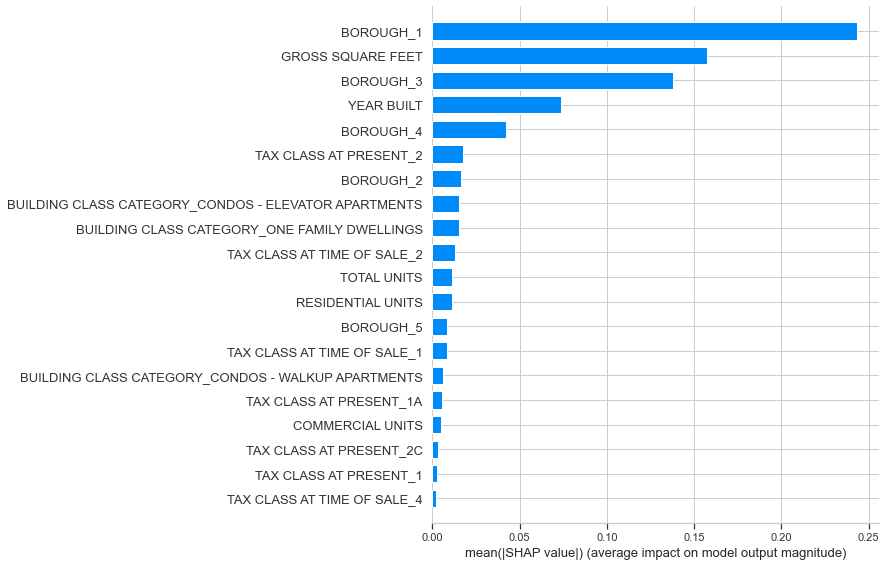

In [866]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

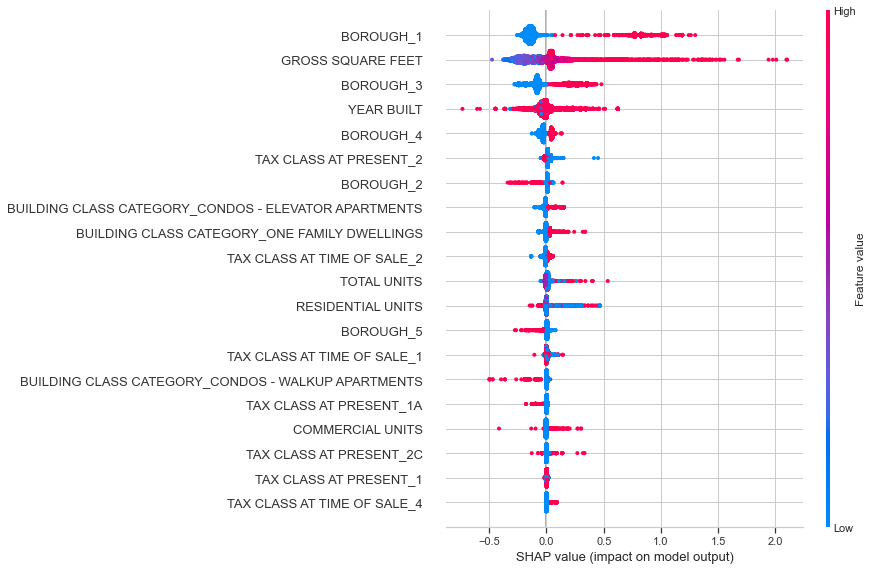

In [863]:
shap.summary_plot(shap_values, X_test)

In [864]:
r2_score(Y_test, Y_pred_lin)


0.34511422238745315

In [759]:
r2_score(Y_test, Y_pred_lasso)


0.33814506556761115

In [760]:
r2_score(Y_test, Y_pred_ridge)


0.3452932611135905

In [789]:
r2_score(Y_test, Y_pred_rf)

0.4564191933593744

In [865]:
r2_score(Y_test, Y_pred_xb)


0.4722830476311337